In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import mrlattice.lattice as lat
from mrlattice.lattice.generate import SuperimposeLatticeArray

FIXED_WIDTH = lat.configure.LatticeArrayScheme.FIXED_WIDTH_SCHEME
FIXED_NUMBER = lat.configure.LatticeArrayScheme.FIXED_NUMBER_SCHEME

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.3"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>
<class '__main__.SuperimposeLatticeArrayPlotWidget'>


In [4]:
%run 0.1.3-02_superimposing_diag_borders.ipynb
clear_output()

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

## Summary

We show how to include `superimpose` in `_propagate`. We highlight the key aspects. Then we also bring to attention the changes to the plot widget.

# Including `superimpose` in `_propagate`

As already mentioned in the previous notebook 0.1.3-02, we now present how to include the superposition algorithm in the `_propagate` method. In the code below we extend the SuperimposeLatticeArray class and just override `_propagate`. We want to highlight two changes.

The first change is the use of `spatial_extend` instead of concatinating lists (tuples in this case) with the + operator. Again, this is in order to implicitly merge neighboring regions with the same resolution. For `_propagate` there is also another big benefit. When appending the right buffer `rbuffer` it can (and does for the last time slice) happen, that the region to append has zero spatial width. But as the neighboring region to append to has the same resolution by design, effectivly the `spatial_extend` does nothing. If we used + instead, we would have added a region with zero width and produced an invalid lattice.

The second change is the addition of the call to `superimpose` where the second argument is just the spatially mirrored time slice of the current loop iteration. We call it on NewSuperimposeLatticeArray which we imported from the previous notebook executing the cells above. By including this call inside the loop over all time slices we essentially pass a single time slice to `superimpose`. Effectivly, we therefore only loop over each time slice once in the course of generating the lattice array. Compared to editing `generate_array` (as shown in 0.1.3-02) this approach has the conceptual benefit of modifying each time slice as its getting appended to the lattice array. So `_propagate` could stop at any iteration over the time slices and the output array would still be a valid lattice array, though only partially complete in temporal direction. If there are any performance benefits to this approach is still to be seen.

Another point to note is that we often pass `[None]` as the output array to lattice modifications. This seems to defeat the purpose of that argument, as now we have to save the output from the methods to be able to get the modified lattices. If we didn't do that and passed an "anonymous" array to the methods, the methods would change that array in place and we would loose the reference to that changed array. We know, that be leaving the output argument empty, we get a new lattice array as the return value anyway.  
However, that return value is a Numpy array. In cases, where we only need a single time slice, that Numpy array would only have a len of 1. As shown by many
(e.g. [Matt Fowler](https://medium.com/coding-with-clarity/speeding-up-python-and-numpy-c-ing-the-way-3b9658ed78f4) or see small test below)
Numpy arrays are slower for small array lengths and especially when using Python objects as elements.
Therefore we hope to gain some performance by passing `[None]` and forcing the output to be a Python list instead. The change in the return type is deliberate and doesn't change that the overall lattice array is still a Numpy array. This also demontrates, that Numpy arrays and Python lists can be interchanged for most of the functionality of LatticeArray.

In [6]:
class NewNewSuperimposeLatticeArray(SuperimposeLatticeArray):
    
    def _propagate(self):
        
        # get resolution of boundaries of lat in units of finest mesh
        coa = 2 ** self.coarse_steps.value
        l_coarsest_t = coa
        l_coarsest_x = l_coarsest_t
        out_t = self.repeat.value * len(self.array)

        out = np.empty(out_t, dtype=object)

        # finest buffer on the right (in coarsest units)
        rbuffer = self.repeat.value - 1

        # calculate each time slice's regions
        for t in range(out_t):
            # number of buffer cells
            q, r = divmod(t, l_coarsest_t)
            temp = self.spatial_extend(
                (((l_coarsest_t, l_coarsest_x, self.buffer.value + q),),),
                (self.array[r],),
                [None],
            )
            # append right buffer + finest_width of finest cells
            temp = self.spatial_extend(
                temp,
                (((1, 1, (rbuffer - q) * coa + self.finest_width.value - 1),),),
                temp,
            )
            # use new superimpose function on new class
            NewSuperimposeLatticeArray.superimpose(
                temp,
                self.spatial_mirror(temp, [None]),
                temp,
            )
            # set time slice
            out[t] = temp[0]

        self._array = out

SuperimposeLatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number o…

Output()

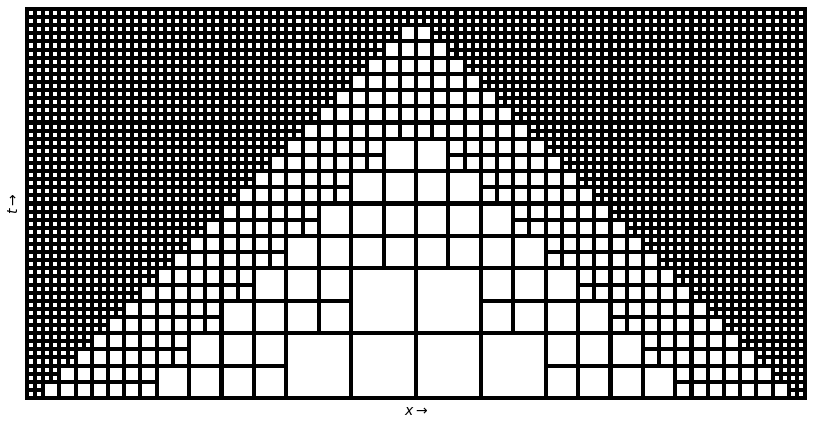

In [7]:
prop_dict = {
    "scheme": FIXED_WIDTH,
    "coarse_steps": 3,
    "borders_width": 12,
    "buffer": 3,    
}
SuperimposeLatticeArrayPlotWidget(lattice=NewNewSuperimposeLatticeArray(**prop_dict))

In [8]:
# numpy vs [None] test
import timeit

for n in range(1, 5002, 1000):
    print("\nsize:", n)
    # numpy
    print("numpy, object:",
          timeit.timeit(f"temp = np.empty({n}, dtype=object); temp[0] = 42", setup="import numpy as np"),
          "\nnumpy, float:",
          timeit.timeit(f"temp = np.empty({n}); temp[0] = 42", setup="import numpy as np"))

    # Python
    print("python:", timeit.timeit(f"temp = [None]*{n}; temp[0] = 42"))


size: 1
numpy, object: 0.5918322679990524 
numpy, float: 0.45382504100052756
python: 0.07847842699993635

size: 1001
numpy, object: 3.1286987909988966 
numpy, float: 0.506238319001568
python: 1.4096500430005108

size: 2001
numpy, object: 5.583637313999134 
numpy, float: 0.5145790669994312
python: 2.6706920439992246

size: 3001
numpy, object: 8.10795686200072 
numpy, float: 0.5268806880012562
python: 3.959232841998528

size: 4001
numpy, object: 10.506573791000847 
numpy, float: 0.5211738199996034
python: 5.298235938000289

size: 5001
numpy, object: 12.841300289999708 
numpy, float: 0.5080221480002365
python: 6.590845757000352


# Updating the LatticeArrayPlotWidget

In the plot above we used a new plot widget SuperimposeLatticeArrayPlotWidget. It's definition is given below. It extends the LatticeArrayPlotWidget class and uses the SuperimposeLatticeArray as the default lattice. It also disables the checkbox for spatial mirroring, as the outputs of SuperimposeLatticeArray are spatially symmetric.

We also cleaned up the existing LatticeArrayPlotWidget. We removed the checkboxes that had no use and shifted the widgets around.

```python
class SuperimposeLatticeArrayPlotWidget(LatticeArrayPlotWidget):
    """Uses `SuperimposeLatticeArray` per default."""
    
    def __init__(self, lattice=None, max_vals=None):
        
        # LatticeArray instance
        new_lattice = lattice if lattice else mrlattice.lattice.generate.SuperimposeLatticeArray()
        super().__init__(lattice=new_lattice, max_vals=max_vals)
        
        # disable spatial mirror
        self.flip_x.disabled = True        
```